# SpO2 Signal quality
Measure Spo2 quality by using cross corelation between two consecutive R PPG segment, and correlation between R and IR segment.

## import module and declare function

In [2]:

import numpy as np
import matplotlib.pyplot as plt
import os,sys
import scipy.signal as signal
from scipy.interpolate import interp1d
import re
import pandas as pd
import math
plt.style.use('ggplot')
sys.path.insert(0, os.path.abspath('../lib'))

import sig_proc as sp
import file_read

import csv

# For read maxim excel file
def maxm_reader(folder, subfolder, source):
    file_path = os.path.join(folder, subfolder)
    for f in os.listdir(file_path):
        if re.findall(source, f):
            ext = os.path.splitext(str(f))[-1].lower()
            if ext == '.csv':
                file_name = str(f)
                f_check = True
                break
            else:
                f_check = False

    if f_check:
        full_path = os.path.join(file_path, file_name)
        reader = csv.reader(open(full_path))

        dataDict = []
        for i, row in enumerate(reader):
            if i == 6:
                first_row = row[:-1] #ignore last empty value
                dataDict = {r:[] for r in first_row}
            elif i > 6:
                if row[0] == 'stop time':
                    break
                for col in range(len(first_row)):
                    if row[col] == '':
                        _value = None
                    else:
                        _value = float(row[col])
                    dataDict[first_row[col]].append(_value)
        return dataDict
    else:
        raise Exception('File not found:{}'.format(file_path))

# Normalize to mv
def value_trans(data):
    data = data*1.2/2097151.0
    return data


# Root mean square error
def rmse_calc(target, prediction):
    error = []
    for i in range(len(target)):
        error.append(target[i] - prediction[i])

    squaredError = []

    for val in error:
        squaredError.append(math.sqrt(val**2))
    rmseError = np.mean(squaredError)
    print(rmseError)

# Mean absolute error
def mae_calc(target, prediction):
    error = []
    for i in range(len(target)):
        error.append(target[i] - prediction[i])

    absError = []
    for val in error:
        absError.append(abs(val))#誤差絕對值
    maeError = np.mean(absError)
    print(maeError)


def sqi_xcorr(x,y):
    x_norm = sp.z_score(x)
    y_norm = sp.z_score(y)
    pxy = max(np.correlate(x_norm, y_norm))
#     pyy = np.correlate(y_norm, y_norm)
    pyy = sum(y_norm*y_norm)
    return (2*pxy)/pyy

# for 2 seconds version 
def sqi_xcorr_2s(x,y):
    x_norm = sp.z_score(x)
    y_norm = sp.z_score(y)
    
    pxy = max(np.correlate(x_norm, y_norm))
#     pyy = np.correlate(y_norm, y_norm)
    pyy = sum(y_norm*y_norm)
    return pxy/pyy

def RMS_amp(data):
    squaredData = []
    for val in data:
        squaredData.append(val**2)
    
    ms = np.mean(squaredData)
    rms = math.sqrt(ms)
    return rms

def spo2_calc(R_AC_component, R_DC_component, IR_AC_component, IR_DC_component, K1, K2):
    # RMS method
    R_divide = R_AC_component/R_DC_component
    R_RMS = RMS_amp(R_divide)

    IR_divide = IR_AC_component/IR_DC_component
    IR_RMS = RMS_amp(IR_divide)
    R_value = R_RMS/ IR_RMS
    
    return K1 + K2*R_value


    
def snr_calc(signal):
    return 20* math.log(np.abs(np.mean(signal)/np.std(signal)),10)


# class spo2_calc:
#     def __init__(self, ):
        

## Main function

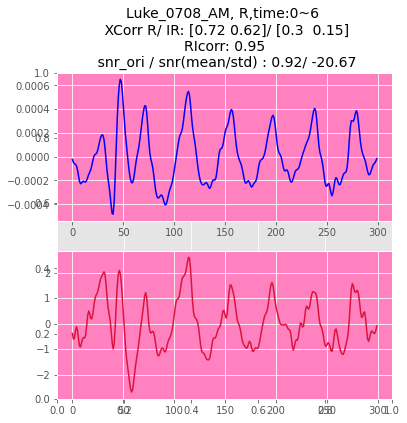

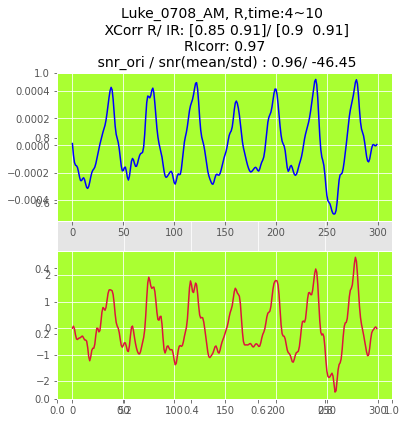

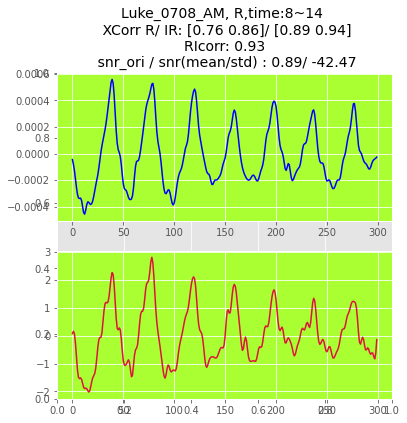

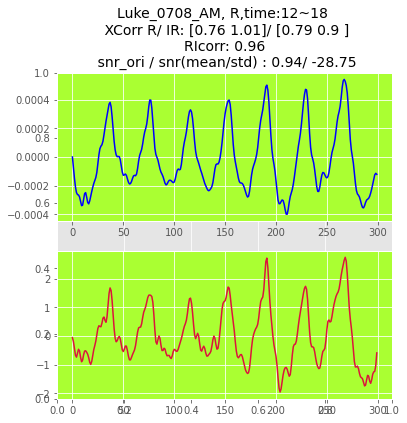

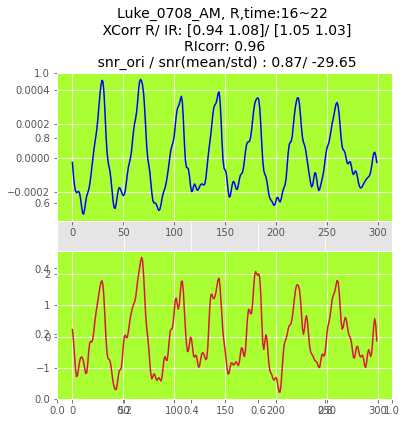

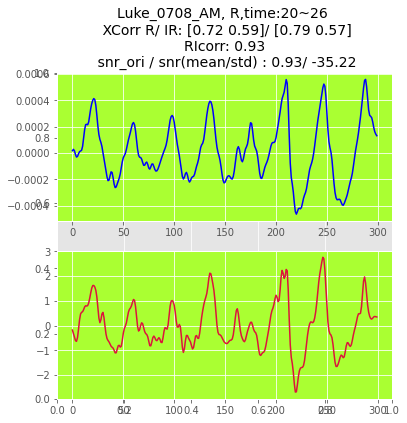

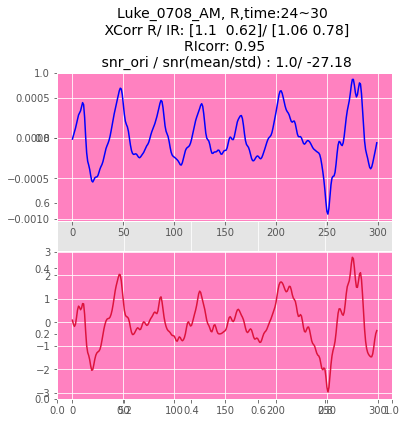

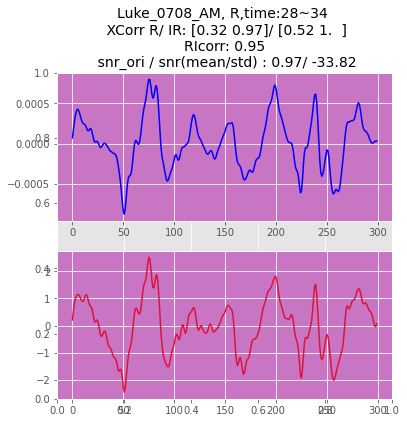

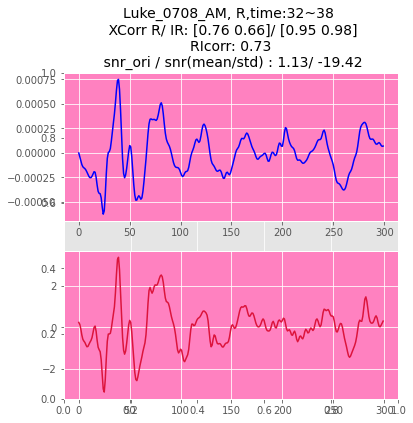

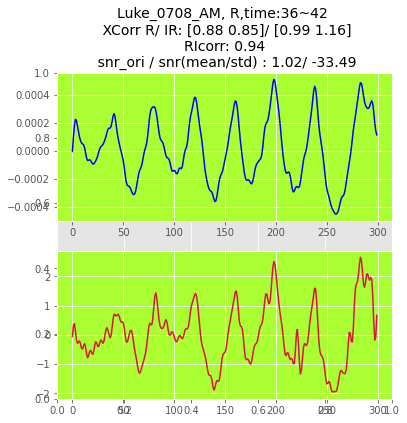

In [10]:
# Select reader
# reader = 'maxm'
# reader = 'njrc_uart'
# subfolder = 'ID01_94'

reader = ''
folder = 'BP_0708 (office)'
# folder = 'R test'
# folder = 'Vital sign_0212(Week)'
# folder = 'finger'

# subfolder = 'Shawn'

subfolder = 'Luke_0708_AM'
# subfolder = 'Shawn_0708_AM'
# subfolder = 'Ryan_0708_AM'
# subfolder = 'Nicole_0708_AM'
# subfolder = 'Vanessa_0708_AM'
# subfolder = 'Yuechi_0708_AM'
# subfolder = 'Eugene_0708_AM'
# subfolder = 'Steven_0708_AM'
''' Select the duration of PPG segment in seconds'''
start_sec = 0
period = 6
overlap = 2
# overlap = 0
# data_length = len(G_y)/sr
hop_length = period - overlap
num_watching_period = 10
# num_watching_period = int((data_length - overlap)/hop_length) -1

SpO2_table = {
    #'spo2_real':[],
    'spo2':[],
    'criteria':[],
    'R_PI':[],
    'IR_PI':[],
    'R_value':[]
}

'''''''''''''''''''''''''''''''''''''''
        Maxim/NJRC reader
'''''''''''''''''''''''''''''''''''''''
spo2_real = []
if reader == 'maxm':
    folder = '../data/MAXIM/MAXIM SpO2'
    # Regression parameter
    K1 = 100.5
    K2 = -19.2
elif reader == 'njrc_uart':
    folder = '../data/NJRC/NJRC SpO2'
    K1 = 121.12
    K2 = -51.77
    # K1 = 114.21
    # K2 = -39.41
else:
    # K1 = 121.12
    # K2 = -51.77
    K1 = 99.813
    K2 = -4.615

date = '0708'
person_list = ['Luke', 'Shawn', 'Ryan', 'Nicole', 'Vanessa', 'Yuechi', 'Eugene', 'Steven']
# subfolder = 'Yuechi_0708_AM'
# subfolder = 'Eugene_0708_AM'
# subfolder = 'Steven_0708_AM'] 



# for person in person_list:
#     subfolder = person + '_' + date + '_AM'

if reader == 'maxm':
    sr = 200
    source = 'MAXM'
    dataDict = maxm_reader(folder, subfolder, source)
    IR_y = dataDict['LEDC2']
    R_y = dataDict['LEDC3']
    IR_y = np.array(IR_y)
    R_y = np.array(R_y)
elif reader == 'njrc_uart':
    # for uart
    sr = 200 
    full_path = os.path.join(folder, subfolder)
    R_y = file_read.load_ppg(full_path, '_R')
    IR_y = file_read.load_ppg(full_path, 'IR')

    R_y = np.array(list(map(value_trans, R_y)))
    IR_y = np.array(list(map(value_trans, IR_y)))
else:
    sr = 50
    full_path = os.path.join("../../data", folder, subfolder)
    IR_y = file_read.load_ppg(full_path, 'IR')
    R_y = load_ppg(full_path, '_R')
    R_y = np.array(list(map(value_trans, R_y)))
    IR_y = np.array(list(map(value_trans, IR_y)))
    

# Filter parameters
b, a = sp.bp_filter(0.5, 10, sr, 4)
for n in range(num_watching_period):
    t1 = start_sec +  (period-overlap) * n
    t2 = t1 + period
    s1 = int(t1*sr)
    s2 = int(t2*sr )

    '''''''''''''''''''''''''''''''''''''''
    Signal Preprocessing
    '''''''''''''''''''''''''''''''''''''''
    IR_segment = np.array(IR_y[s1:s2])
    R_segment = np.array(R_y[s1:s2])
    
    '''IR Preprocess'''
    filt_IR = signal.filtfilt(b,a, IR_segment)

    ''' R Preprocess'''
    filt_R = signal.filtfilt(b,a, R_segment)


    ''' SQI_XCORR '''
    R_AC_component = sp.butter_highpass_filter(R_segment, 0.5, sr, 4)
#     IR_AC_component = sp.butter_highpass_filter(raw_IR, 0.5, sr, 4)

#     filtered_norm_R = sp.z_score(filtered_R)
#     filtered_norm_IR = sp.z_score(filtered_IR)
    tm_length = sr*2
    tl = sr*1
    template_R = filt_R[0:tm_length]
    template_IR = filt_IR[0:tm_length]
    xcorr_value = []
    IR_xcorr_value = []
    for seg in range(2):

        test_signal_R = filt_R[tm_length+tl*seg : tm_length + tl*seg + tl]
        test_signal_IR = filt_IR[tm_length+tl*seg : tm_length + tl*seg + tl]

        xcorr_value.append(sqi_xcorr(test_signal_R, template_R))
        IR_xcorr_value.append(sqi_xcorr(test_signal_IR, template_IR))


    R_xcorr_value_2s = sqi_xcorr_2s(filt_R[tm_length:], template_R)
    IR_xcorr_value_2s = sqi_xcorr_2s(filt_IR[tm_length:],template_R)

    ''' R and IR correlation '''
    ricorr = sp.corrcoef(filt_R[tm_length:], filt_IR[tm_length:])

    # RMS method
    R_DC_component = sp.butter_lowpass_filter(R_segment, 5, sr, 4)  
    IR_DC_component = sp.butter_lowpass_filter(IR_segment, 5, sr, 4)

    R_divide = filt_R/R_DC_component
    R_RMS = RMS_amp(R_divide)

    IR_divide = filt_IR/IR_DC_component
    IR_RMS = RMS_amp(IR_divide)
    R_value = R_RMS/ IR_RMS
    spo2_value =  K1 + K2*R_value


    SpO2_table['spo2'].append(spo2_value)
    SpO2_table['criteria'].append(subfolder)
    SpO2_table['R_PI'].append(R_RMS)
    SpO2_table['IR_PI'].append(IR_RMS)
    SpO2_table['R_value'].append(R_value)
    
    '''''''''''''''''''''''''''''''''''
    plot filgure
    '''''''''''''''''''''''''''''''''''
    font_size = 14
    fig_size  = (6,6)
        
    fig = plt.figure(figsize=fig_size)
    smooth_R = sp.move_avg(filt_R[tm_length:], int(sr/10))
    # snr_db = sn_sqi(smooth_R,R_AC_component[tm_length:])
    snr_mean_std = snr_calc(R_AC_component[tm_length:])
    ssqi = sp.snr_calc(smooth_R, R_AC_component[tm_length:])
    sqi_str1 = 'XCorr R/ IR: {}/ {}\n'.format(np.round(xcorr_value,2), np.round(IR_xcorr_value,2))
    sqi_str2 = 'RIcorr: {}'.format(np.round(ricorr,2))
    # str1 = '\n R value 3s/test:{}, {}'.format(np.round(R_ver2,2), np.round(R_test, 2))
    # str2 = '\n SpO2 3s/ test: {}/ {}'.format(np.round(spo2_ver2,2), np.round(spo2_test, 2))
    # str3 = '\n RPI 3s/ test: {}/ {}'.format(np.round(R_RMS*100,2), np.round(R_RMS_test*100, 2))
    str4 = '\n snr_ori / snr(mean/std) : {}/ {}'.format(np.round(ssqi,2), np.round(snr_mean_std,2))
    str5 = '\n R/IR 2s xcorr: {}/ {}'.format(np.round(R_xcorr_value_2s, 2), np.round(IR_xcorr_value_2s, 2))
    plt.title('{}, R,time:{}~{} \n '.format(subfolder,t1,t2) + sqi_str1 + sqi_str2 + str4,  fontsize=font_size)
    ax1 = fig.add_subplot(211)
    plt.plot(filt_IR, color='blue')
    # plt.plot(IR_sample_list[tm_length:], sp.z_score(filtered_IR[tm_length:]), color='blue')
    ax2 = fig.add_subplot(212)
    plt.plot(sp.z_score(filt_R), color='crimson')
    # plt.plot(R_sample_list[tm_length:], sp.z_score(filtered_R[tm_length:]), color='crimson')
    


    if xcorr_value[0] < 0.5 or xcorr_value[1] < 0.5 or ricorr < 0.7:
        if ricorr <0.6 and (xcorr_value[0] > 0.6 and xcorr_value[1] > 0.6):
            print('Bad quality but R and IR not similar but the signal shows 60% similarity on pre-signal, time:{}~{}, xcorr:{}'.format(t1,t2,np.round(xcorr_value,2)))        
        ax1.set_facecolor('xkcd:orchid')
        ax2.set_facecolor('xkcd:orchid')

    elif (xcorr_value[0] > 0.6 and xcorr_value[0]< 0.7) or (xcorr_value[1] > 0.6 and xcorr_value[1] < 0.7):
        ax1.set_facecolor('xkcd:pink')
        ax2.set_facecolor('xkcd:pink')
    else:
        ax1.set_facecolor('xkcd:lime')
        ax2.set_facecolor('xkcd:lime')


In [11]:
import pandas as pd

pd.DataFrame(SpO2_table)


,spo2,criteria,R_PI,IR_PI,R_value
0,97.878184,Luke_0708_AM,0.000133,0.000317,0.419245
1,97.984538,Luke_0708_AM,0.000125,0.000315,0.396200
2,97.826433,Luke_0708_AM,0.000137,0.000319,0.430459
3,98.033666,Luke_0708_AM,0.000121,0.000314,0.385555
4,97.991775,Luke_0708_AM,0.000109,0.000277,0.394632
5,97.892131,Luke_0708_AM,0.000131,0.000314,0.416223
6,97.502033,Luke_0708_AM,0.000212,0.000422,0.500751
7,97.274104,Luke_0708_AM,0.000250,0.000455,0.550140
8,97.664613,Luke_0708_AM,0.000146,0.000313,0.465523
9,97.525925,Luke_0708_AM,0.000156,0.000315,0.495574


In [9]:
0.000133/0.000317

0.4195583596214511

In [8]:
os.path.exists(full_path)

True